In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
import os
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from keras.models import load_model

In [6]:
#folder directories
dataset = '/content/drive/MyDrive/dental/dental_dataset_procisteni_2'

In [7]:
img_height, img_width = 224, 224

datagen =  keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
                                                        
train_generator = datagen.flow_from_directory(dataset,
                                            batch_size=32,
                                            class_mode='categorical',
                                            target_size=(img_height, img_width),
                                            subset='training',
                                            shuffle = True,
                                            seed=2)

validation_generator = datagen.flow_from_directory(dataset,
                                            batch_size=32,
                                            class_mode='categorical',
                                            target_size=(img_height, img_width),
                                            subset='validation',
                                            shuffle=False,
                                            seed=2)

Found 641 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [9]:
value, counts = np.unique(train_generator.classes,return_counts=True)
dict(zip(value,counts))

{0: 320, 1: 321}

In [10]:
value, counts = np.unique(validation_generator.classes,return_counts=True)
dict(zip(value,counts))

{0: 80, 1: 80}

In [ ]:
!pip install -q -U albumentations

In [ ]:
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.1.0 is successfully installed


In [ ]:
import albumentations as A
from tensorflow.keras.utils import Sequence

class AugmentDataGenerator(Sequence):
    def __init__(self, datagen, augment=None):
        self.datagen = datagen
        if augment is None:
            self.augment = A.Compose([])
        else:
            self.augment = augment

    def __len__(self):
        return len(self.datagen)

    def __getitem__(self, x):
        images, *rest = self.datagen[x]
        augmented = []
        for image in images:
            image = self.augment(image=image)['image']
            augmented.append(image)
        # print(type(augemented))
        # print(type(*rest))
        # raise Exception
        return (np.array(augmented), *rest)


In [ ]:
train_generator = AugmentDataGenerator(train_generator, A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip()
    #A.Rotate(limit=30),
    #A.RandomBrightness(limit=0.1),
    #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    #A.RandomContrast(limit=0.2, p=0.5),
    #A.GridDistortion(distort_limit=0.2,p=.1),
    #A.OpticalDistortion(p=0.3),
    #A.ElasticTransform(sigma=20)
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


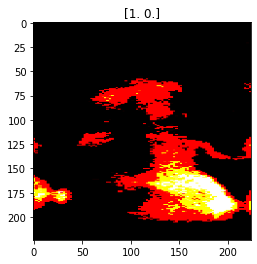

In [ ]:
 for x,y in train_generator:
   plt.imshow(x[0,...],cmap='gray')

   plt.title(str(y[0]))
   plt.show()
   break

In [ ]:
value, counts = np.unique(validation_generator.classes,return_counts=True)
dict(zip(value,counts))

{0: 81, 1: 80}

# New

In [12]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
print(type(vgg_model.layers))

<class 'list'>


In [ ]:
# Freeze four convolution blocks
for layer in vgg_model.layers[:int(0.6*len(vgg_model.layers))]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x) layers
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x) 

transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
transfer_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
checkpoint = ModelCheckpoint('drive/MyDrive/vgg_cavity_1.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import layers, models, Model, optimizers

learning_rate= 1e-5
opt = Adam(lr = learning_rate)
transfer_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = transfer_model.fit(train_generator, epochs=80, validation_data=validation_generator, verbose=1, callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/80
21/21 [==============================] - 11s 455ms/step - loss: 0.8269 - accuracy: 0.5402 - val_loss: 0.7140 - val_accuracy: 0.5590

Epoch 00001: val_accuracy improved from -inf to 0.55901, saving model to drive/MyDrive/vgg_cavity_1.h5
Epoch 2/80
21/21 [==============================] - 9s 435ms/step - loss: 0.5833 - accuracy: 0.6842 - val_loss: 0.6380 - val_accuracy: 0.5714

Epoch 00002: val_accuracy improved from 0.55901 to 0.57143, saving model to drive/MyDrive/vgg_cavity_1.h5
Epoch 3/80
21/21 [==============================] - 9s 438ms/step - loss: 0.5136 - accuracy: 0.7539 - val_loss: 0.6072 - val_accuracy: 0.6149

Epoch 00003: val_accuracy improved from 0.57143 to 0.61491, saving model to drive/MyDrive/vgg_cavity_1.h5
Epoch 4/80
21/21 [==============================] - 9s 439ms/step - loss: 0.4658 - accuracy: 0.7941 - val_loss: 0.5767 - val_accuracy: 0.6708

Epoch 00004: val_accuracy improved from 0.61491 to 0.67081, saving model to drive/MyDrive/vgg_cavity_1.h5
Epoch 

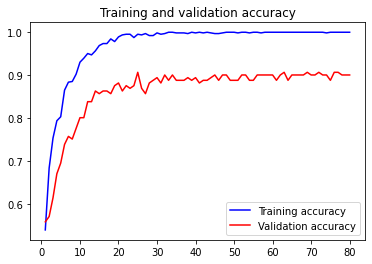

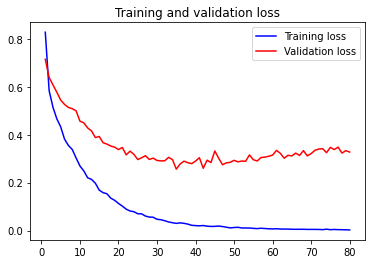

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig('Loss.jpg')

In [13]:
transfer_model = load_model('/content/drive/MyDrive/vgg_cavity_new_99_90.h5')

In [14]:
prediction = transfer_model.predict_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [15]:
import math
preds = np.argmax(prediction,axis=1)

In [16]:
true_classes = validation_generator.classes

numpy.ndarray

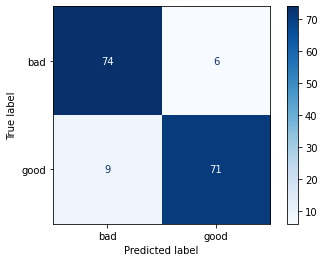

In [25]:
cm = confusion_matrix(true_classes, preds)
labels = validation_generator.class_indices.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [19]:
transfer_model.evaluate(validation_generator)

5/5 [==============================] - 79s 16s/step - loss: 0.2978 - accuracy: 0.9062


[0.2978416085243225, 0.90625]

In [20]:
report = classification_report(true_classes, preds)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        80
           1       0.92      0.89      0.90        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

